# Donnée textuelles - Partie 1

Comme nous l'avons vu précédemment, les algorithmes utilisés en ML demandent que les entrées soient sous formes numériques, qu'il s'agisse des données elles-mêmes ou des classes. Pour cette raison, nous avons dans le cours précédent encodés numériquement les classes de variété d'iris, tout en créant un mapping permettant de faire correspondre le nom de chaque variété à sa forme numérique.

Cependant, s'il est relativement aisé d'encoder un ensemble de noms de classes, qui sont alors en nombre fini, quand est-il de données textuelles brutes, tel que des avis, des romans ou des articles ? Comment peut-on représenter la sémantique ou la syntaxe d'un texte de manière numérique ? Une grande partie des recherches en TAL (ou NLP) du point de vue du Machine Learning consiste à trouver de nouvelles méthodes pour répondre à cette problématique.

Dans ce cours, nous allons voir les premières méthodes utilisés pour encoder des données textuelles, ce qui nous permettra de traiter un problème d'analyse de sentiment, qui est un cas récurrent de classification en TAL.

---

Nous allons travailler à partir de la version française du ``amazon_reviews`` dataset. Contrairement aux datasets que nous avons utilisés précédemment, celui-ci est déjà divisé en train, validation et test sets. Ceux-ci sont enregistrés au format JSON, mais nous pouvons tout de même les ouvrir avec ``pandas``:

### Importer les données

In [1]:
import pandas as pd
trainset = pd.read_json('data/amazon_reviews/fr/train/dataset_fr_train.json', lines=True)
devset = pd.read_json('data/amazon_reviews/fr/dev/dataset_fr_dev.json', lines=True)
testset = pd.read_json('data/amazon_reviews/fr/test/dataset_fr_test.json', lines=True)

In [3]:
trainset.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,fr_0424335,product_fr_0297678,reviewer_fr_0961886,1,A déconseiller - Article n'a fonctionné qu'une...,Brumisateur à pompe,fr,beauty
1,fr_0452615,product_fr_0613288,reviewer_fr_0857499,1,Si vous voulez être déçu achetez le produit ! ...,Insatisfaisant,fr,baby_product
2,fr_0407673,product_fr_0571250,reviewer_fr_0383240,1,"Écran de mauvaise qualité, car il s'use en peu...",Ne recommande pas,fr,pc
3,fr_0579191,product_fr_0030168,reviewer_fr_0729693,1,Cet engin ne sert à rien les sons sont pourris...,A éviter!,fr,musical_instruments
4,fr_0931533,product_fr_0468261,reviewer_fr_0734066,1,Très beau produit mais la grue n'a pas fonctio...,Déçue,fr,toy


Ce dataset regroupe les avis laissés par les acheteurs sur Amazon. Il est intéressant puisque chaque avis est associé à plusieurs catégories, ce qui permet d'utiliser ce dataset pour différents problèmes. Ici, la note laissée par l'acheteur pour un produit est indiquée dans la colonne 'stars' et exprime sa satisfaction quant au produit. 

Pour résoudre notre problématique d'analyse de sentiments, nous n'allons garder que les colonnes review_body et stars, que nous renommerons 'texts' et 'classes'. Il nous faudra appliquer ce filtre aux trois datasets (train, dev et test). Nous allons donc écrire une fonction pour appliquer le même filtrage facilement:

### Filtrer et renommer les données

In [4]:
def filter_df(df, list_columns):
    """
    Retourne le DataFrame avec uniquement les colonnes demandées
    """
    filtered_df = df[list_columns]
    return filtered_df

In [5]:
keep_col = ['review_body', 'stars'] # liste des colonnes que l'on souhaite garder
train = filter_df(trainset, keep_col) 
dev = filter_df(devset, keep_col)
test = filter_df(testset, keep_col)
train.head() # on visualise les premieres lignes du df 

,review_body,stars
0,A déconseiller - Article n'a fonctionné qu'une...,1
1,Si vous voulez être déçu achetez le produit ! ...,1
2,"Écran de mauvaise qualité, car il s'use en peu...",1
3,Cet engin ne sert à rien les sons sont pourris...,1
4,Très beau produit mais la grue n'a pas fonctio...,1


Nous allons créer une fonction pour renommer automatiquement les colonnes de la même façon sur les trois datasets:

In [6]:
def rename_columns(df, list_rename):
    """
    Retourne un DF avec les noms de colonnes changées par celles de list_rename
    """
    df.columns = list_rename
    return df

In [7]:
list_rename = ['texts', 'classes']
train = rename_columns(train, list_rename)
dev = rename_columns(dev, list_rename)
test = rename_columns(test, list_rename)
train.head()

,texts,classes
0,A déconseiller - Article n'a fonctionné qu'une...,1
1,Si vous voulez être déçu achetez le produit ! ...,1
2,"Écran de mauvaise qualité, car il s'use en peu...",1
3,Cet engin ne sert à rien les sons sont pourris...,1
4,Très beau produit mais la grue n'a pas fonctio...,1


## Visualisation des classes

Comme on peut le voir ci-dessus, les classes sont déjà sous forme numérique: il n'y a donc pas besoin d'utiliser le ``LabelEncoder`` de ``scikit-learn`` pour transformer les noms des classes. Cependant, il est toujours important de visualiser la distribution des classes, afin de s'assurer que certaines classes soient déséquilibrées:

<Axes: xlabel='classes'>

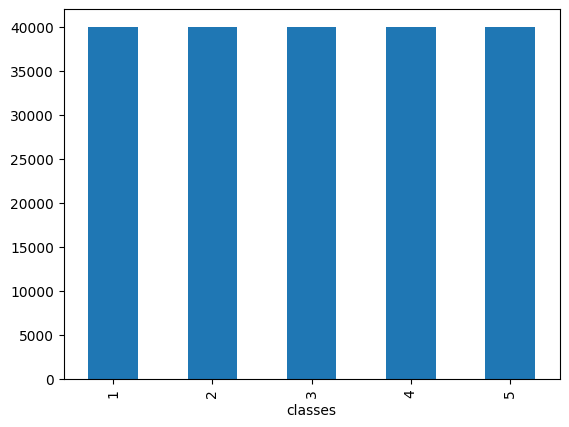

In [8]:
train['classes'].value_counts().plot.bar()

Avec le diagramme ci-dessus, on constate qu'il y a 40 000 exemples pour chaque classe, ce qui fait qu'elles sont équilibrées.

Puisque nous venons d'effectuer un certain nombre d'étapes de prétraitement, et que l'on aura sans doute besoin de réutiliser ces données, nous allons sauvegarder ces trois DataFrame sur le disque afin de pouvoir les charger sans avoir à appliquer de nouveaux ces prétraitements:

In [9]:
# ici on précise index = None pour éviter que l'index ne soit conservé
# comme une colonne du fichier
import os

os.makedirs('data/multiclass', exist_ok=True)

train.to_csv('data/multiclass/as_train.csv', index = None)
dev.to_csv('data/multiclass/as_dev.csv', index = None)
test.to_csv('data/multiclass/as_test.csv', index = None)

## Réduction du nombre de classes

La classification multiclasses en TAL peut être une tâche compliquées. A moins d'utiliser des techniques plus avancées, il est difficile d'obtenir de bons résultats lors de l'entraînement. Nous allons donc transformer légèrement ce dataset de telle sorte à n'avoir que deux classes: positif et négatif.

Notre dataset est composé de 5 classes: **Très mauvais** (1), **Mauvais** (2), **Neutre** (3), **Bon** (4), **Très bon** (5). Pour le réduire à deux classes nous allons regrouper les classes 1 et 2 dans 'Négatif', les classes 4 et 5 dans 'Positif' et supprimer la classe 3 (étant neutre, on ne peut facilement l'assimiler à l'une des deux autres classes).

Pour remplacer un ensemble de données dans un DataFrame, on peut utiliser la fonction ``replace``. Celle-ci prend en entrée une liste de données à remplacer et une liste de même taille des nouvelles données:

In [10]:
def replace_values(df, col, old_data, new_data):
    """
    Remplace old_data par new_data dans colonne col du DataFrame df
    """
    df[col].replace(old_data, new_data, inplace = True)
    return df

In [11]:
old_data = [1, 2, 4, 5] # classes que l'on souhaite remplacer
new_data = [0, 0, 1, 1] # valeurs respectives par lesquelles on remplace

bi_train = replace_values(train, 'classes', old_data, new_data)
bi_dev = replace_values(dev, 'classes', old_data, new_data)
bi_test = replace_values(test, 'classes', old_data, new_data)

bi_train.head()

/var/folders/g9/npfr2mks4118dkv7g8ckgccr0000gn/T/ipykernel_41125/1923629457.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace(old_data, new_data, inplace = True)
/var/folders/g9/npfr2mks4118dkv7g8ckgccr0000gn/T/ipykernel_41125/1923629457.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].replace(old_data, new_data, i

,texts,classes
0,A déconseiller - Article n'a fonctionné qu'une...,0
1,Si vous voulez être déçu achetez le produit ! ...,0
2,"Écran de mauvaise qualité, car il s'use en peu...",0
3,Cet engin ne sert à rien les sons sont pourris...,0
4,Très beau produit mais la grue n'a pas fonctio...,0


<Axes: xlabel='classes'>

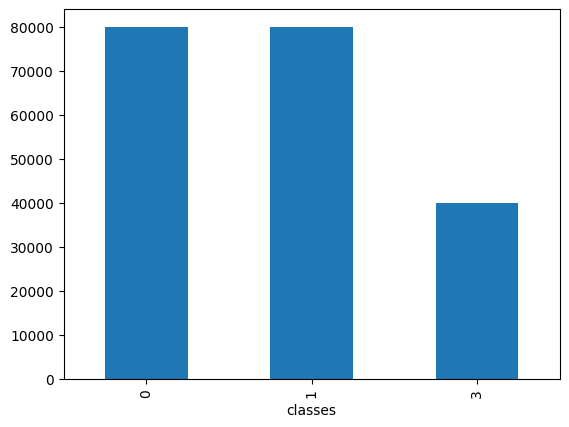

In [12]:
bi_train.classes.value_counts().plot.bar()

### Supprimer les valeurs neutres

Ci-dessous, on filtre le DataFrame de telle sorte à ne conserver que les lignes pour lesquelles la valeur de 'classes' est tout sauf 3:

In [13]:
bi_train = bi_train[bi_train['classes'] != 3]
bi_dev = bi_dev[bi_dev['classes'] != 3]
bi_test = bi_test[bi_test['classes'] != 3]

In [14]:
bi_train['classes'].value_counts()

classes
0    80000
1    80000
Name: count, dtype: int64

<Axes: xlabel='classes'>

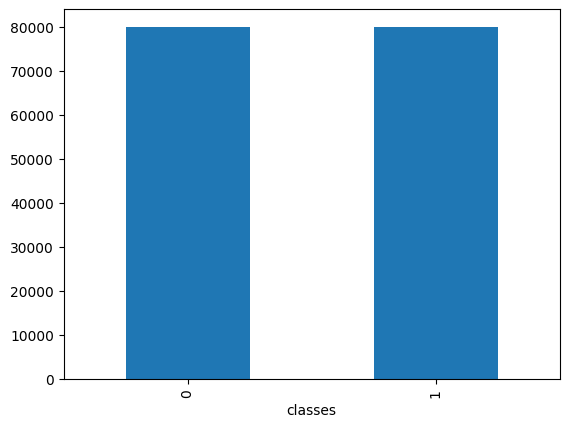

In [15]:
bi_train.classes.value_counts().plot.bar()

A nouveau, nous allons sauvegarder sur le disque ces fichiers de telle sorte à pouvoir réutiliser ces données sans effectuer à nouveau les prétraitements:

In [15]:
import os

os.makedirs('data/binary', exist_ok=True)
    
bi_train.to_csv('data/binary/bi_as_train.csv', index = None)
bi_dev.to_csv('data/binary/bi_as_dev.csv', index = None)
bi_test.to_csv('data/binary/bi_as_test.csv', index = None)

# Entraîner un modèle de classification de textes

In [16]:
import pandas as pd 

bi_train = pd.read_csv('data/binary/bi_as_train.csv')
bi_dev = pd.read_csv('data/binary/bi_as_dev.csv')
bi_test = pd.read_csv('data/binary/bi_as_test.csv')

bi_train

,texts,classes
0,A déconseiller - Article n'a fonctionné qu'une...,0
1,Si vous voulez être déçu achetez le produit ! ...,0
2,"Écran de mauvaise qualité, car il s'use en peu...",0
3,Cet engin ne sert à rien les sons sont pourris...,0
4,Très beau produit mais la grue n'a pas fonctio...,0
...,...,...
159995,Très jolies boucles! Très belle qualité ! Elle...,1
159996,Superbe. Ultra rapide. Tres bel écran. Il y a ...,1
159997,facile d'utilisation mais un peu lourd,1
159998,livré vite et bon produit,1


### Note

Bien que l'analyse de sentiment soit le problème de base pour la classification en TAL, il s'agit en vérité d'un problème loin d'être trivial. Si cette tâche est relativement aisée avec deux classes, il suffit d'en ajouter une troisième (généralement neutre) pour baisser drastiquement les résultats.

## Feature Extraction

Comme nous l'avons vu au début de ce cours, chaque dataset est composé de ``samples`` (lignes) et de ``features`` (colonnes). Ces features doivent être au format numérique pour pouvoir être utilisées par les algorithmes. Cependant, notre colonne ``text`` n'est pas en soit une feature puisqu'on ne peut l'utiliser tel quel.  Il faut donc trouver un moyen d'extraire les caractéristiques de cette colonne. En Machine-Learning, cette étape est appelée ``Feature-Extraction``, et est une étape cruciale dans le processus d'entraînement d'un modèle.

## Bag-of-Words

Une des plus simples méthodes de Feature-Extraction pour le texte est la méthode dite du ``Bag-of-Words``. Cette méthode ne s'intéresse qu'aux mots eux-mêmes, sans se préoccuper des paragraphes ou de la syntaxe. Elle consiste pour un ensemble de documents donné à compter le nombre d'occurrences de chaque mot. En se débarassant de la syntaxe ou de l'organisation des textes, on consitue donc un ``sac de mots`` contenant un vocabulaire, c'est-à-dire un ensemble fini de mots. On peut alors représenter chaque document par le nombre d'occurrences de chaque mot qu'il contient.

Etablir un sac de mots se réalise en trois étapes:

* La tokenization
* La constitution du vocabulaire
* L'encodage

## Tokenization

La tokenization est le processus consistant à transformer une ou plusieurs chaînes de caractères continues en un ensemble d'unités distinctes. L'unité ainsi obtenue est appelée token. Grâce à la tokenization, il devient possible de traitrer indépendemment chaque unité d'un texte, facilitant ainsi leur encodage.

Généralement, l'unité choisie est le mot (plus exactement l'unité lexicale), mais on peut également tokenizer à des niveaux plus fins, comme celui des sous-mots ou des caractères.


```
"La batterie est arrivée cassée au niveau de la nappe de connexion."

Mot : ['La', 'batterie', 'est', 'arrivée', 'cassée', 'au', 'niveau', 'de', 'la', 'nappe', 'de', 'connexion']

Sous-mot : ['La', 'batterie', 'est', 'arriv', '##ée', 'cass', '##ée', 'au', 'niveau', 'de', 'la', 'nappe', 'de', 'connexion']

Caractères : ['L', 'a', 'b', 'a', 't', 't', 'e', 'r', 'i', 'e', ...]

```

Tokenizer est une tâche loin d'être triviale: on ne peut en effet pas simplement diviser les phrases aux niveaux des espaces seulements. Il suffit de prendre la phrase ci-dessus pour s'en rendre compte:


``Y-a-t-il de nouveaux arrivants?``

Si l'on divise aux espaces simplements, on obtient ``['Y-a-t-il', 'de', 'nouveaux', 'arrivants?']``. On vient donc bien qu'il y-a au moins trois unités lexicales distinctes dans le premier token, et deux dans le dernier token. Ainsi, tokenizer demande de prendre en compte les différents signes graphiques et les particularités de chaque langues pour être efficace. 

### Constituer le vocabulaire

Un vocabulaire, ou lexique, est un ensemble fini de tokens. Ce vocabulaire sera notre véritable sac de mot qui nous servira de référence pour encoder nos documents. 

Lorsqu'on utilise la méthode de sac de mots, chaque mot du vocabulaire devient une des features que l'on utilise pour entraîner le modèle. Ainsi, si l'on a 40 000 samples dans notre dataset, et que notre vocabulaire contient 10 000 mots, on a donc une matrice de ``(40 000 x 10 000)``.

## Encodage

Dans le modèle de sac de mots, l'étape d'encodage va consister à associer une valeur numérique à chaque token contenu dans le document que l'on traite. Cette valeur numérique diffère selon la méthode d'encodage que l'on choisit. Ainsi pour chaque mot du vocabulaire, on peut:

1. indiquer si celui-ci est présent (1) ou non (0) dans le document
2. indiquer sa fréquence d'apparition, c'est-à-dire combien de fois celui-ci apparaît dans le document
3. indiquer son poids par rapport aux documents et aux autre mots du vocabulaire (ce qui correspond à la méthode TF-IDF)

## CountVectorizer

Comme le ``LabelEncoder``, le ``CountVectorizer`` est un transformer: il possède une fonction ``fit()`` lui permettant de s'adapter aux données ainsi qu'une fonction ``transform()`` lui permettant de transformer ces données sous une autre forme. Ici, ``CountVectorizer()`` permet de transformer un corpus de texte en vecteurs d'occurrences de mots. ``CountVectorizer`` se charge lui-même de la tokenization, pour laquelle il prend en charge certains aspects de prétraitement, comme la suppression des ponctuations ou le passage de l'intégrité du texte en minuscule. Nous verrons plus tard comment adapter ces paramètres.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer


# Parmi les hyperparamètres importants :
# * lowercase : passe le texte en minuscule
# * stop_words : soit 'english' pour utiliser liste de mots vides par défaut en anglais, sinon fournir une liste de termes
# * strip_accent : supprime les accents
# * token_pattern : expression régulière pour indiquer comment tokenizer 
# * analyser : tokenization au niveau des mots ('words'), ou caractères ('char')
# * min_df, max_df : fréquence minimale / maximale à retenir 
# * max_features : taille maximale du vocabulaire
# * ngram_range : taille des ngrams à considérer (1,1) = unigram, (1, 2) = unigramme et bigrammes, (2,2) = bigrames, etc.

# on indique max_features = 1000 afin de ne garder que les 1000 termes les plus fréquents
# cela permet aussi de ne pas surcharger la mémoire
vectorizer = CountVectorizer(max_features=1000)

In [18]:
# on apprend le vocabulaire à l'aide de la méthode fit()
corpus = bi_train['texts']
vectorizer.fit(corpus)

CountVectorizer(max_features=1000)

### Transformer les données
Nous pouvons désormais encoder les données textuelles des jeux de données de validation et de test, et entraîner un modèle de classificaton de textes.

In [19]:
# on encode les données à l'aide de la méthode transform()
# on encode les données d'entraînement
X_train= vectorizer.transform(bi_train['texts'])
y_train =  bi_train['classes']
print("Forme de la matrice :", X_train.shape)

# on encode les données de validation
X_dev = vectorizer.transform(bi_dev['texts'])
y_dev = bi_dev['classes']
print("Forme de la matrice :", X_dev.shape)

# on encode les données de test
X_test = vectorizer.transform(bi_test['texts'])
y_test = bi_test['classes']
print("Forme de la matrice :", X_test.shape)

Forme de la matrice : (160000, 1000)
Forme de la matrice : (4000, 1000)
Forme de la matrice : (4000, 1000)


In [21]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2863761 stored elements and shape (160000, 1000)>

In [20]:
# on doit employer la méthode toarray() pour récupérer les valeurs de la matrice
# on peut ensuite l'utiliser pour créer un DataFrame
vec_df = pd.DataFrame(data = X_train.toarray(),
                        columns = vectorizer.get_feature_names_out())

# chaque document (ligne) est désormais encodé sous la forme d'un vecteur de 48035 mots
vec_df

,10,100,12,15,20,2018,30,absolument,abîmé,accessoires,...,était,étanche,étant,état,étoile,étoiles,étui,été,éviter,être
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
vec_df[vec_df!= 0].loc[0]

,10,100,12,15,20,2018,30,absolument,abîmé,accessoires,...,était,étanche,étant,état,étoile,étoiles,étui,été,éviter,être
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nous pouvons maintenant utiliser ces données numériques de la même manière que les données que nous avions pour le ``iris-dataset``, et les donner en entrée à un algorithme tel que KNN our LogisticRegression:

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

# on va sauvegarder les resultats de chaque modele dans ce dictionnaire
results = {}

# on entraine le modele 
lr_1 = LogisticRegression()
lr_1.fit(X_train, y_train)

# eval sur jeu de validation
lr1_pred_val = lr_1.predict(X_dev)
print(classification_report(y_dev, lr1_pred_val))

# eval sur jeu de test
lr1_pred_test = lr_1.predict(X_test)
print(classification_report(y_test, lr1_pred_test))

results['lr1'] =  float(f1_score(y_test, lr1_pred_test))


              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2000
           1       0.87      0.88      0.87      2000

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2000
           1       0.88      0.88      0.88      2000

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



## Supprimer les mots vides

Les mots-vides, ou mots-outils, sont tous les mots tels que déterminants, pronoms, prépositions, etc. qui jouent un rôle syntaxique mais ne participent pas au niveau sémantique du texte. Comme décrit par la Loi de Zipf, ce sont les mots que l'on retrouve le plus dans un corpus, et qui par conséquent y sont les moins importants. 

Puisque la méthode sac de mots ne s'intéresse pas à l'organisation du texte, il est recommandé d'en supprimer les mots vides afin d'en réduire le nombre de dimensions.

Comme nous l'avons vu plus tôt, ``CountVectorizer`` prend en charge différents aspects du prétraitement, en particulier la suppression des mots vides. Cependant, il fonctionne par défaut sur l'anglais et ne propose pas de prétraitements pour le français. Ainsi, pour supprimer les mots vides français, il faut lui en fournir une liste, que vous trouverez dans le dossier ``data`` de ce cours. 

Nous allons dans la cellule ci-dessous charger ce fichier dans une liste, puis le donner en argument à ``CountVectorizer``:

In [24]:
fr_stopwords = []
with open('data/fr_stopwords.txt') as f:
  for line in f:
    # on enleve les sauts de lignes et eventuels espaces en trop
    line = line.strip()
    fr_stopwords.append(line)
fr_stopwords[:10]

['a',
 'abord',
 'absolument',
 'afin',
 'ah',
 'ai',
 'aie',
 'aient',
 'aies',
 'ailleurs']

In [25]:
stop_vectorizer = CountVectorizer(stop_words= fr_stopwords)
stop_vectorizer.fit(corpus)

X_train= stop_vectorizer.transform(bi_train['texts'])
y_train =  bi_train['classes']
print("Forme de la matrice :", X_train.shape)

# on encode les données de validation
X_dev = stop_vectorizer.transform(bi_dev['texts'])
y_dev = bi_dev['classes']
print("Forme de la matrice :", X_dev.shape)

# on encode les données de test
X_test = stop_vectorizer.transform(bi_test['texts'])
y_test = bi_test['classes']
print("Forme de la matrice :", X_test.shape)

/Users/nicolasgutehrle/opt/anaconda3/envs/cours/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  warnings.warn(


Forme de la matrice : (160000, 47467)
Forme de la matrice : (4000, 47467)
Forme de la matrice : (4000, 47467)


In [26]:
# on entraine le modele 
stop_lr = LogisticRegression()
stop_lr.fit(X_train, y_train)

# eval sur jeu de validation
stop_lr_pred_val = stop_lr.predict(X_dev)
print(classification_report(y_dev, stop_lr_pred_val))

# eval sur jeu de test
stop_lr_pred_test = stop_lr.predict(X_test)
print(classification_report(y_test, stop_lr_pred_test))

results['stop_lr'] =  float(f1_score(y_test, stop_lr_pred_test))


              precision    recall  f1-score   support

           0       0.86      0.85      0.85      2000
           1       0.85      0.86      0.85      2000

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      2000
           1       0.85      0.87      0.86      2000

    accuracy                           0.86      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.86      0.86      0.86      4000



/Users/nicolasgutehrle/opt/anaconda3/envs/cours/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Etendre le contexte avec les n-grammes

Comme nous l'avons déjà dit, le sac de mot est du point de vue linguistique uniquement constitué d'un vocabulaire: la syntaxe de la phrase, et l'organisation générale du texte sont totalement mis de côté. Pourtant, un même vocabulaire dans différentes organisations peut donner de multiples sens, comme dans les deux phrases ci-dessous (en anglais):

* It's good, it's not so bad
* It's bad, it's not so good

Avec le sac de mot, nous perdons toutes subtilités apportées par l'organisation de chaque phrase, ce qui est problématique lorsque l'on cherche à traiter du texte comme dans le cas de l'analyse de sentiments.

Une solution pour faire face à ce problème tout en conservant la méthode du sac de mots est considérer les ``n-grammes``. "[Un n-gramme est une sous-séquence de n éléments construite à partir d'une séquence donnée](https://fr.wikipedia.org/wiki/N-gramme)" (Wikipedia). Jusque là, nous avons tokenizé les phrases au niveau de l'unité lexicale: nous avons donc pris des n-gramme de 1, ou ``unigramme``:

``[It, 's, good, it, 's, not, so, bad]``

Cependant, nous pouvons sélectionner des n-grammes de la taille n que nous souhaitons, comme des bigrammes (n-grammes de 2) ou trigrammes (n-grammes de 3). Par défaut, les tokens de ``CountVectorizer()`` sont des unigrammes, mais il est possible de choisir la taille des n-grammes en jouant avec le paramètre ``ngram_range``:

### N-grammes
* it's good it's not so bad
* unigramme: (it 's good it 's not so bad
* bigramme (it's) ('s good) (it 's) ('s not) (not so) (so bad)
* trigramme (it's good) ('s good it) (good it 's) (it 's not) ('s not so) (not so bad)

In [29]:
# ngram_range = (x, y)
# ou x est le nombre minimal d'elements à prendre en compte
# et y le nombre maximal

# essayer ici avec différentes combinaisons
# ngram_range = (1,2)
ngram_range = (2,2)

ngram_vectorizer = CountVectorizer(ngram_range=ngram_range)

ngram_vectorizer.fit(bi_train['texts'])

X_train= ngram_vectorizer.transform(bi_train['texts'])
y_train =  bi_train['classes']
print("Forme de la matrice :", X_train.shape)

# on encode les données de validation
X_dev = ngram_vectorizer.transform(bi_dev['texts'])
y_dev = bi_dev['classes']
print("Forme de la matrice :", X_dev.shape)

# on encode les données de test
X_test = ngram_vectorizer.transform(bi_test['texts'])
y_test = bi_test['classes']
print("Forme de la matrice :", X_test.shape)



Forme de la matrice : (160000, 800985)
Forme de la matrice : (4000, 800985)
Forme de la matrice : (4000, 800985)


In [30]:
# on entraine le modele 
ngram_lr = LogisticRegression()
ngram_lr.fit(X_train, y_train)

# eval sur jeu de validation
ngram_lr_pred_val = ngram_lr.predict(X_dev)
print(classification_report(y_dev, ngram_lr_pred_val))

# eval sur jeu de test
ngram_lr_pred_test = ngram_lr.predict(X_test)
print(classification_report(y_test, ngram_lr_pred_test))

results['ngram_lr'] =  float(f1_score(y_test, ngram_lr_pred_test))


              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2000
           1       0.90      0.93      0.91      2000

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2000
           1       0.89      0.91      0.90      2000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



## Changer la tokenization

En général, la tokenization se fait au niveau des mots, mais elle est également intéressante au niveau des caractères lorsqu'on travaille par exemple sur un aspect morphologique (détection de la langue, création d'un autre tokenizer, ...). Pour cela, on précise l'analyzer comme étant ``'char'`` dans ``CountVectorizer`` (par défaut, celui-ci est fixé sur ``'word'``):

In [31]:
# ici, on considère des bigrames de caractères
analyzer = 'char'
ngram_range = (2,2)
bi_char_vectorizer = CountVectorizer(analyzer = analyzer, ngram_range=ngram_range)

bi_char_vectorizer.fit(bi_train['texts'])

X_train= bi_char_vectorizer.transform(bi_train['texts'])
y_train =  bi_train['classes']
print("Forme de la matrice :", X_train.shape)

# on encode les données de validation
X_dev = bi_char_vectorizer.transform(bi_dev['texts'])
y_dev = bi_dev['classes']
print("Forme de la matrice :", X_dev.shape)

# on encode les données de test
X_test = bi_char_vectorizer.transform(bi_test['texts'])
y_test = bi_test['classes']
print("Forme de la matrice :", X_test.shape)


Forme de la matrice : (160000, 3569)
Forme de la matrice : (4000, 3569)
Forme de la matrice : (4000, 3569)


In [32]:
# on entraine le modele 
bi_char_lr = LogisticRegression()
bi_char_lr.fit(X_train, y_train)

# eval sur jeu de validation
bi_char_lr_pred_val = bi_char_lr.predict(X_dev)
print(classification_report(y_dev, bi_char_lr_pred_val))

# eval sur jeu de test
bi_char_lr_pred_test = bi_char_lr.predict(X_test)
print(classification_report(y_test, bi_char_lr_pred_test))

results['bi_char_lr'] =  float(f1_score(y_test, bi_char_lr_pred_test))


              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2000
           1       0.82      0.84      0.83      2000

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      2000
           1       0.82      0.85      0.83      2000

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



/Users/nicolasgutehrle/opt/anaconda3/envs/cours/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Suivant le problème que vous traitez ou suivant le besoin d'améliorer les résultats obtenu par votre modèle lors de l'entraînement, changer la taille des n-gramme peut s'avérer utile. Cependant, si ici notre corpus est ridicule, prendre des n-grammes trop grands sur de larges corpus risque d'augmenter grandement le nombre de feature, ce qui à terme déteriorera les performances du modèle ainsi que l'usage de la mémoire.

Il est donc conseillé d'utiliser des unigrammes, bigrammes, trigrammes, et au plus, des n-grammes de 5 éléments.

In [33]:
# ici, on ne conserve que des mots (pas de valeurs numériques)
token_pattern = '[a-zA-Z]+'
word_vectorizer = CountVectorizer(token_pattern=token_pattern)

word_vectorizer.fit(bi_train['texts'])

X_train= word_vectorizer.transform(bi_train['texts'])
y_train =  bi_train['classes']
print("Forme de la matrice :", X_train.shape)

# on encode les données de validation
X_dev = word_vectorizer.transform(bi_dev['texts'])
y_dev = bi_dev['classes']
print("Forme de la matrice :", X_dev.shape)

# on encode les données de test
X_test = word_vectorizer.transform(bi_test['texts'])
y_test = bi_test['classes']
print("Forme de la matrice :", X_test.shape)


Forme de la matrice : (160000, 39050)
Forme de la matrice : (4000, 39050)
Forme de la matrice : (4000, 39050)


In [34]:
# on entraine le modele 
word_lr = LogisticRegression()
word_lr.fit(X_train, y_train)

# eval sur jeu de validation
word_lr_pred_val = word_lr.predict(X_dev)
print(classification_report(y_dev, word_lr_pred_val))

# eval sur jeu de test
word_lr_pred_test = word_lr.predict(X_test)
print(classification_report(y_test, word_lr_pred_test))

results['word_lr'] =  float(f1_score(y_test, word_lr_pred_test))


              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2000
           1       0.88      0.88      0.88      2000

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2000
           1       0.88      0.88      0.88      2000

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



/Users/nicolasgutehrle/opt/anaconda3/envs/cours/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# TF-IDF

Une autre méthode pour encoder les termes dans un contexte de sac de mots est par les poids TF-IDF. Plutôt que des fréquences, cette méthode assigne des poids à chaque terme, qui diffèrent d'un document à un autre. Ainsi, plus un terme sera fréquent dans l'ensemble du corpus et plus son poids sera petit (ce qui permet d'éliminer les mots vides, qui sont les termes les plus fréquents d'une langue). La méthode TF-IDF permet donc d'obtenir des représentations plus intéressantes des termes que par la fréquence simple.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TfidfVectorizer fonctionne comme CountVectorizer, mais retourne des poids plutôt que des fréquences.
# Tous ses hyperparamètres sont similaires à ceux de CountVectorizer.
# A nouveau, on ne garde que les 1000 termes les plus importants pour 
tfidf_vec = TfidfVectorizer(max_features=1000)

# on peut entraîner et transformer les données en une seule commande
X_train = tfidf_vec.fit_transform(bi_train['texts'])
y_train =  bi_train['classes']
print("Forme de la matrice :", X_train.shape)

# on encode les données de validation
X_dev = tfidf_vec.transform(bi_dev['texts'])
y_dev = bi_dev['classes']
print("Forme de la matrice :", X_dev.shape)

# on encode les données de test
X_test = tfidf_vec.transform(bi_test['texts'])
y_test = bi_test['classes']
print("Forme de la matrice :", X_test.shape)


Forme de la matrice : (160000, 1000)
Forme de la matrice : (4000, 1000)
Forme de la matrice : (4000, 1000)


In [12]:
vec_df = pd.DataFrame(data = X_train.toarray(),
                        columns = vectorizer.get_feature_names_out())

# chaque document (ligne) est désormais encodé sous la forme d'un vecteur de 48035 mots
vec_df

,10,100,12,15,20,2018,30,absolument,abîmé,accessoires,...,était,étanche,étant,état,étoile,étoiles,étui,été,éviter,être
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.184416
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122976,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
159996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
159997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
159998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [36]:
# on entraîne un modèle à partir des représentations TFIDF des textes
tfidf_lr = LogisticRegression()
tfidf_lr.fit(X_train, y_train)

# eval sur jeu de validation
tfidf_lr_pred_val = tfidf_lr.predict(X_dev)
print(classification_report(y_dev, tfidf_lr_pred_val))

# eval sur jeu de test
tfidf_lr_pred_test = tfidf_lr.predict(X_test)
print(classification_report(y_test, tfidf_lr_pred_test))

results['tfidf_lr'] =  float(f1_score(y_test, tfidf_lr_pred_test))



              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2000
           1       0.87      0.88      0.88      2000

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2000
           1       0.89      0.87      0.88      2000

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



### Visualisation des performances

On peut visualiser les scores de nos modèles, afin de déterminer lequel est le meilleur pour la tâche d'analyse de sentiments binaires.

In [37]:
for k, v in results.items():
    print(k, v)

lr1 0.8779389694847424
stop_lr 0.8569306930693069
ngram_lr 0.9019316493313522
bi_char_lr 0.8348894348894349
word_lr 0.8827345309381237
tfidf_lr 0.8764556962025316


{'lr1': 0.8779389694847424, 'stop_lr': 0.8569306930693069, 'ngram_lr': 0.9019316493313522, 'bi_char_lr': 0.8348894348894349, 'word_lr': 0.8827345309381237, 'tfidf_lr': 0.8764556962025316}


<Axes: >

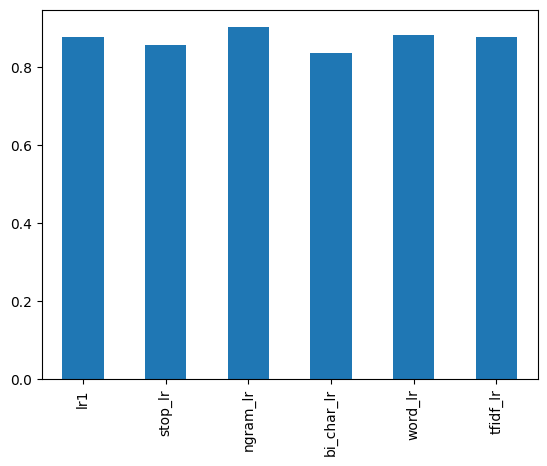

In [50]:
print(results)
viz = pd.Series(results)
viz.plot.bar()

## Pipeline


Une fois un modèle entraîné, il est important de le sauvegarder sur le disque afin de conserver l'entraînement ainsi que pour l'utiliser dans d'autres programmes. Cependant, il est important de sauvegarder tout outil de prétraitement (comme un vectorizer) utilisé pendant la phase d'entraînement afin d'appliquer les mêmes traitements à ces nouvelles données.

Précédemment, nous avons sauvegardé notre modèle ainsi que son vectorizer sur le disque. Cependant, ceci peut s'avérer laborieux lors de la mise en production puisqu'il faut appliquer la même chaîne de traitements que lors de l'entraînement. Pour faciliter cette étape, il est possible de créer à l'aide de ``scikit-learn`` une ``Pipeline``: celle-ci permet d'associer les différentes étapes de prétraitement ainsi que le modèle au sein d'un seul et même objet. 

Cet objet ``Pipeline`` se comporte comme un modèle et peut donc s'entraîner sur des données avant d'être utilisé pour prédire de nouveaux résultats. A la différence des autres modèles, il appliquera directement tout prétraitement qu'on le lui aura ajouté, tel qu'un vectorizer.

In [38]:
from sklearn.pipeline import Pipeline

# Pipeline prend en argument une liste de tuple
# Le 1er element du tuple est le nom de l'objet, le 2nd est l'objet lui-meme
pipe = Pipeline(
    [
     ('vectorizer', TfidfVectorizer(max_features=1000)), # 1ere couche : vectorizer
     ('logreg', LogisticRegression()) # Derniere couche : modele
    ]
)
# on entraine le Pipeline comme si l'on entrainait un modele
pipe.fit(bi_train['texts'], bi_train['classes'])



Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=1000)),
                ('logreg', LogisticRegression())])

In [39]:
# eval sur jeu de validation
pipe_pred_val = pipe.predict(bi_dev['texts'])
print(classification_report(bi_dev['classes'], pipe_pred_val))

# eval sur jeu de test
pipe_pred_test = pipe.predict(bi_test['texts'])
print(classification_report(bi_test['classes'], pipe_pred_test))



              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2000
           1       0.87      0.88      0.88      2000

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2000
           1       0.89      0.87      0.88      2000

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



### Sauvegarder un modèle

Maintenant que nous avons entraîné notre modèle, et que nous pouvons être relativement satisfaits des résultats, il ne nous reste plus qu'à le sauvegarder sur le disque, afin de pouvoir plus tard le charger et l'utiliser dans d'autres programmes. 

Les modèles entraînés avec ``scikit-learn`` peuvent être sauvegardés à l'aide de ``pickle`` ou ``joblib``. ``pickle`` et ``joblib`` sont deux librairies permettant de sauvegarder des données au format binaire sur le disques. Historiquement, joblib** est plus adapté pour sauvegarder de grosses masses de données, même si la différence n'est plus tout à fait vraie aujourd'hui. Cependant, sauvegarder un fichier avec **joblib** est syntaxiquement plus léger qu'avec **pickle**.

Voir la documentation de scikit-learn pour plus d'exemples : https://scikit-learn.org/stable/modules/model_persistence.html

In [40]:
from joblib import dump
import os
# os.makedirs permet de créer des dossiers
# le paramètre  exist_ok=True indique que ça ne pose pas souci si le dossier existe déjà
os.makedirs('data/pipe_model', exist_ok=True)

# on emploie la commande dump de joblib pour sauvegarder la pipeline
# on utilise l'extension joblib
dump(pipe, 'data/pipe_model/model.joblib')

['data/pipe_model/model.joblib']

## Charger un modèle 

In [41]:
from joblib import load 
# on peut charger le modèle à l'aide de la fonction load()
loaded_pipe = load('data/pipe_model/model.joblib')
loaded_pipe

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=1000)),
                ('logreg', LogisticRegression())])

In [42]:
bi_train = pd.read_csv('data/binary/bi_as_train.csv')
bi_dev = pd.read_csv('data/binary/bi_as_dev.csv')
bi_test = pd.read_csv('data/binary/bi_as_test.csv')

bi_train

,texts,classes
0,A déconseiller - Article n'a fonctionné qu'une...,0
1,Si vous voulez être déçu achetez le produit ! ...,0
2,"Écran de mauvaise qualité, car il s'use en peu...",0
3,Cet engin ne sert à rien les sons sont pourris...,0
4,Très beau produit mais la grue n'a pas fonctio...,0
...,...,...
159995,Très jolies boucles! Très belle qualité ! Elle...,1
159996,Superbe. Ultra rapide. Tres bel écran. Il y a ...,1
159997,facile d'utilisation mais un peu lourd,1
159998,livré vite et bon produit,1


In [43]:
# eval sur jeu de validation
pipe_pred_val = loaded_pipe.predict(bi_dev['texts'])
print(classification_report(bi_dev['classes'], pipe_pred_val))

# eval sur jeu de test
pipe_pred_test = loaded_pipe.predict(bi_test['texts'])
print(classification_report(bi_test['classes'], pipe_pred_test))


              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2000
           1       0.87      0.88      0.88      2000

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2000
           1       0.89      0.87      0.88      2000

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



## Références

Feature-extraction ne concerne pas que le traitement des données textuelles: elle concerne le traitement de n'importe quel type de features. On peut ainsi répartir les valeurs d'une colonne en trois colonnes ou à l'inverse, réduire le nombre de colonnes utilisées. A DVLP

* https://towardsdatascience.com/feature-extraction-techniques-d619b56e31be